In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Pretrained BERT Model and Tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name)

# Check if MPS (Apple GPU) is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
bert_model.to(device)

# Function to Extract BERT Embeddings in Batches
def get_bert_embedding(texts, batch_size=4, max_length=128):
    bert_model.eval()  # Set BERT to evaluation mode (no gradient calculations)
    all_embeddings = []

    # Process data in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT embeddings"):
        batch_texts = texts[i:i + batch_size]

        # Tokenize the batch
        encoded_inputs = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

        # Move inputs to MPS (Apple GPU)
        input_ids = encoded_inputs["input_ids"].to(device)
        attention_mask = encoded_inputs["attention_mask"].to(device)

        with torch.no_grad():  # Disable gradients for efficiency
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract CLS token representation (Sentence-Level Embedding)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move to CPU for sklearn

        all_embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings
    return np.vstack(all_embeddings)

In [4]:
df_spam = pd.read_csv(r'spam.csv')
df_spam['spam']=df_spam['Category'].apply(lambda x: 1 if x=='spam' else 0)

# Sample Data
X_texts , y_labels = df_spam['Message'].tolist(), df_spam['spam'].tolist()

# Convert Text to BERT Embeddings
X_features = get_bert_embedding(X_texts)

Extracting BERT embeddings: 100%|███████████| 1393/1393 [00:32<00:00, 42.40it/s]


In [5]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

## Logistic 

In [6]:
# Train Logistic Regression Model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict on Test Data
y_pred = clf.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9910


## BiLSTM + CNN

In [7]:
def get_bert_embedding(texts, batch_size=4, max_length=128):
    bert_model.eval()  # Set BERT to evaluation mode (no gradient calculations)
    all_embeddings = []

    # Process data in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT embeddings"):
        batch_texts = texts[i:i + batch_size]

        # Tokenize the batch
        encoded_inputs = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

        # Move inputs to MPS (Apple GPU)
        input_ids = encoded_inputs["input_ids"].to(device)
        attention_mask = encoded_inputs["attention_mask"].to(device)

        with torch.no_grad():  # Disable gradients for efficiency
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

        # **Fix: Extract FULL SEQUENCE embeddings instead of just CLS**
        batch_embeddings = outputs.last_hidden_state.cpu().numpy()  # (batch_size, 128, 768)

        all_embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings
    return np.vstack(all_embeddings)  # Shape: (batch_size, 128, 768)

In [8]:
def create_bilstm_cnn_model(input_shape=(128, 768), lstm_units=128, cnn_filters=128, kernel_size=3, num_classes=2):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # BiLSTM Layer
    lstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(inputs)

    # Conv1D Layer
    conv_output = tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=kernel_size, activation="relu", padding="same")(lstm_output)
    conv_output = tf.keras.layers.GlobalMaxPooling1D()(conv_output)

    # Fully Connected Layers
    dense = tf.keras.layers.Dense(64, activation="relu")(conv_output)
    dropout = tf.keras.layers.Dropout(0.3)(dense)

    # Output Layer
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(dropout)

    # Define Model
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

# Create Model (Now Works!)
model = create_bilstm_cnn_model()


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print Model Summary
model.summary()

2025-02-02 12:29:05.043869: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-02-02 12:29:05.043905: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-02-02 12:29:05.043915: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-02-02 12:29:05.043953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-02 12:29:05.043972: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 256)       │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025,346 (3.91 MB)

 Trainable params: 1,025,346 (3.91 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Convert Text to BERT Embeddings
X_features = get_bert_embedding(X_texts)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

y_train = np.array(y_train, dtype=np.int32) 
y_test = np.array(y_test, dtype=np.int32) 

Extracting BERT embeddings: 100%|███████████| 1393/1393 [00:32<00:00, 42.97it/s]


In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=4, shuffle=True,
                    validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/30


2025-02-02 12:29:38.832584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1115/1115 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.8531 - loss: 0.3059 - val_accuracy: 0.9883 - val_loss: 0.0426
Epoch 2/30
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.9900 - loss: 0.0379 - val_accuracy: 0.9883 - val_loss: 0.0404
Epoch 3/30
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9921 - loss: 0.0313 - val_accuracy: 0.9928 - val_loss: 0.0341
Epoch 4/30
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9919 - loss: 0.0193 - val_accuracy: 0.9937 - val_loss: 0.0321
Epoch 5/30
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.9965 - loss: 0.0131 - val_accuracy: 0.9928 - val_loss: 0.0329
Epoch 6/30
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.9971 - loss: 0.0080 - val_accuracy: 0.9937 - val_loss: 0.0354
Epoch 7/30
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - accuracy: 0.9997 - loss: 0.0032 - val_accuracy: 0.9919 - val_loss: 0.0375


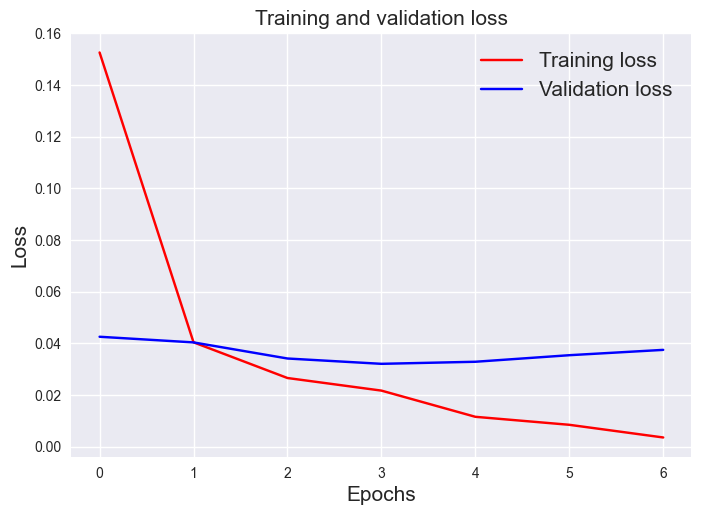

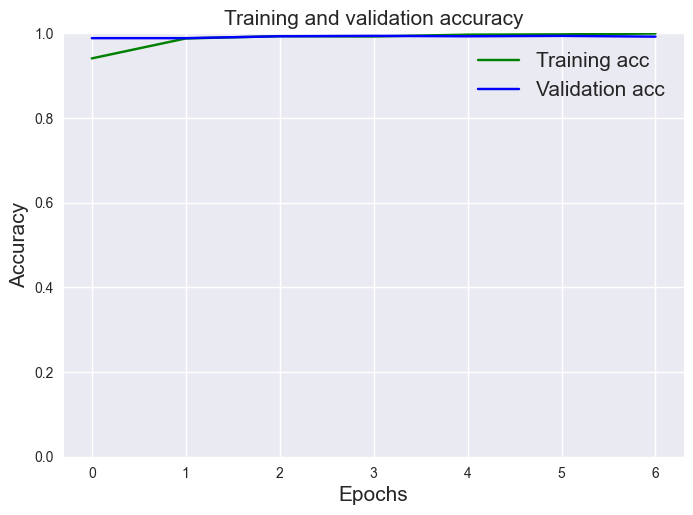

In [15]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0,1))
plt.show()

In [16]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

pred_classes = np.argmax(pred, axis=1)  # Convert softmax outputs to class labels

print("---Test Set Results---")
accuracy = accuracy_score(y_test, pred_classes)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(classification_report(y_test, pred_classes))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step 
---Test Set Results---

Test Accuracy: 0.9937
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       0.99      0.97      0.98       149

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.99      1115
weighted avg       0.99      0.99      0.99      1115



Text(0.5, 1.0, 'Confusion Matrix')

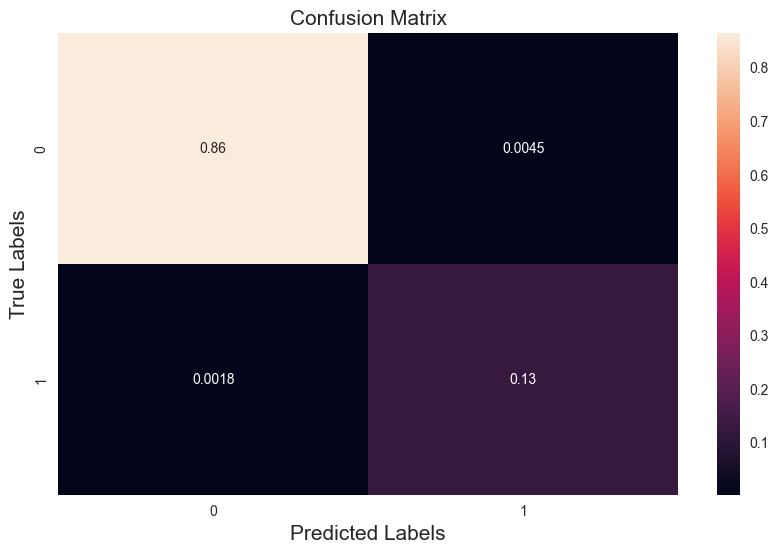

In [17]:
import seaborn as sns


matrix = confusion_matrix(pred_classes, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
# ax.xaxis.set_ticklabels([0,1], size=15)
# ax.yaxis.set_ticklabels([0,1], size=15);